In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Carga de datos

In [2]:
train_data = pd.read_csv("data/train.csv")
print(train_data.shape)
train_data.sample(3)

(7613, 5)


,id,keyword,location,text,target
4212,5983,hazard,NaN,8/6/2015@1:08 PM: HAZARD IN HIGH TRAFFIC AREA ...,1
5246,7502,oil%20spill,Amarillo,'California: Spring Oil Spill Estimate Grows '...,1
2786,4008,disaster,chillin at ceder rapids,Beautiful disaster // Jon McLaughlin is such a...,0


In [3]:
test_data = pd.read_csv("data/test.csv")
print(test_data.shape)
test_data.sample(3)

(3263, 4)


,id,keyword,location,text
3151,10460,wild%20fires,Where e'er the mood takes me,@MrRat395 Are those wild fires getting anywher...
858,2812,cyclone,NYC,@orochinagicom GIGATECH CYCLONE
379,1220,blizzard,Florida,Whoa! This new legend will be fun! http://t.co...


In [4]:
train_data['Dataset'] = 'Training'
test_data['Dataset'] = 'Testing'
data = pd.concat([train_data, test_data], ignore_index=True)
print(data.shape)
data.sample(3)

(10876, 6)


,id,keyword,location,text,target,Dataset
1529,2211,chemical%20emergency,"Virginia, United States",#Illinois: Emergency units simulate a chemical...,1.0,Training
7013,10054,twister,Downtown Oklahoma City,@TheBuffShow @TheTwisterOkc My boyfriend wants...,0.0,Training
4446,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1.0,Training


# Análisis exploratorio

In [5]:
data.isna().sum()

id             0
keyword       87
location    3638
text           0
target      3263
Dataset        0
dtype: int64

## Keyword

A particular keyword from the tweet (may be blank).

In [6]:
data.keyword.value_counts(dropna=False).head(20)

NaN                   87
landslide             50
lightning             50
loud%20bang           50
mass%20murder         50
massacre              50
mayhem                50
meltdown              50
military              50
mudslide              50
natural%20disaster    50
nuclear%20disaster    50
nuclear%20reactor     50
obliterate            50
obliterated           50
obliteration          50
oil%20spill           50
outbreak              50
pandemonium           50
panic                 50
Name: keyword, dtype: int64

In [7]:
data['keyword'] = data.keyword.str.replace('%20', ' ')

## Location

The location the tweet was sent from (may be blank or invented by the user).

In [9]:
data.location.value_counts(dropna=False).head(20)

NaN                3638
USA                 141
New York            109
United States        65
London               58
Canada               42
Nigeria              40
Worldwide            35
India                35
Los Angeles, CA      34
UK                   33
Kenya                32
Washington, DC       31
Mumbai               28
United Kingdom       26
California           25
Australia            25
Los Angeles          24
San Francisco        23
Chicago, IL          23
Name: location, dtype: int64

## Test

The text of the tweet.

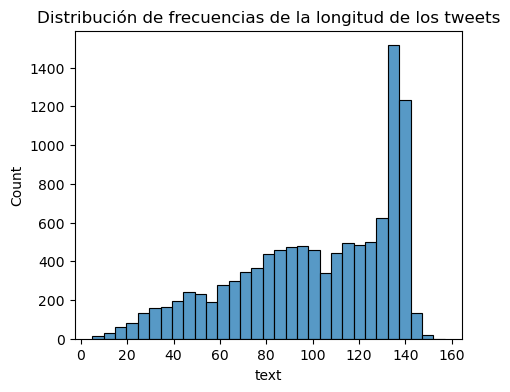

In [10]:
fig, ax = plt.subplots(figsize=(5,4))
sns.histplot(data.text.str.len())
ax.set_title('Distribución de frecuencias de la longitud de los tweets');

## Target

It denotes whether a tweet is about a real disaster (1) or not (0). The values are kind of balanced.

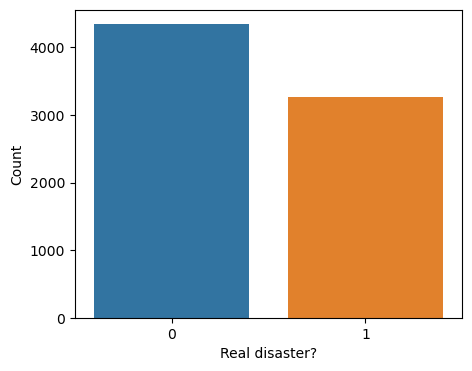

In [11]:
tmp = train_data.target.value_counts().to_frame().reset_index().rename(columns={'index':'Real disaster?', 'target':'Count'})
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(tmp, x='Real disaster?', y='Count');

# Preparación de los datos

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_tmp, y_tmp = data.loc[ data.Dataset=='Training', 'text' ], data.loc[ data.Dataset=='Training', 'target' ]
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, stratify=y_tmp, test_size=0.2, random_state=42)
X_test = data.loc[ data.Dataset=='Testing', 'text' ]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((6090,), (1523,), (3263,), (6090,), (1523,))

# Baseline model

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2023-01-08 12:24:40.373449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Testing encoders

### universal-sentence-encoder

In [47]:
%%time
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-01-06 13:49:53.153921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 13.1 s, sys: 4.73 s, total: 17.8 s
Wall time: 39 s


In [48]:
tensors = embed(["bananas", "grapes", "house", "building", "tree", "plants"])
np.inner([tensors[0]], [tensors[1]]), np.inner([tensors[0]], [tensors[2]]), np.inner([tensors[2]], [tensors[3]]), np.inner([tensors[4]], [tensors[5]])

(array([[0.4892403]], dtype=float32),
 array([[0.14636]], dtype=float32),
 array([[0.45283696]], dtype=float32),
 array([[0.47080904]], dtype=float32))

### universal-sentence-encoder-cmlm/en-large

In [49]:
%%time
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-large/1")

CPU times: user 26.1 s, sys: 6.65 s, total: 32.8 s
Wall time: 1min 40s


In [50]:
tensors = encoder( preprocessor(["bananas", "grapes", "house", "building", "tree", "plants"]) )["default"]
np.inner([tensors[0]], [tensors[1]]), np.inner([tensors[0]], [tensors[2]]), np.inner([tensors[2]], [tensors[3]]), np.inner([tensors[4]], [tensors[5]])

(array([[976.92114]], dtype=float32),
 array([[913.7648]], dtype=float32),
 array([[1024.3728]], dtype=float32),
 array([[1000.0454]], dtype=float32))

### tf2-preview/nnlm-en-dim128-with-normalization

In [52]:
%%time
embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")

CPU times: user 5.13 s, sys: 2.33 s, total: 7.47 s
Wall time: 16.9 s


In [55]:
tensors = embed(["bananas", "grapes", "house", "building", "tree", "plants"])
np.inner([tensors[0]], [tensors[1]]), np.inner([tensors[0]], [tensors[2]]), np.inner([tensors[2]], [tensors[3]]), np.inner([tensors[3]], [tensors[4]]), np.inner([tensors[4]], [tensors[5]])

(array([[0.5450651]], dtype=float32),
 array([[0.07753104]], dtype=float32),
 array([[0.59674144]], dtype=float32),
 array([[0.31855476]], dtype=float32),
 array([[0.47336307]], dtype=float32))

### roberta_en_cased_L-24_H-1024_A-16

In [56]:
%%time
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1")
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-24_H-1024_A-16/1", trainable=True)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


CPU times: user 31.6 s, sys: 7.36 s, total: 39 s
Wall time: 1min 17s


In [57]:
tensors = encoder( preprocessor(["bananas", "grapes", "house", "building", "tree", "plants"]) )["pooled_output"]
np.inner([tensors[0]], [tensors[1]]), np.inner([tensors[0]], [tensors[2]]), np.inner([tensors[2]], [tensors[3]]), np.inner([tensors[4]], [tensors[5]])

(array([[251.89647]], dtype=float32),
 array([[251.76776]], dtype=float32),
 array([[251.4343]], dtype=float32),
 array([[251.37146]], dtype=float32))

## Building model

In [15]:
model = Sequential(name="classifier-disaster-tweets")
model.add( hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1", trainable=False, input_shape=(), dtype=tf.string) )
model.add( Dense(64, activation='relu') )
model.add( Dense(1, activation='sigmoid') )
model.summary()

Model: "classifier-disaster-tweets"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124,651,009
Trainable params: 8,321
Non-trainable params: 124,642,688
_________________________________________________________________


In [65]:
METRICS = [
      'accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [66]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=2)

Epoch 1/100
191/191 - 3s - loss: 0.5613 - accuracy: 0.7297 - precision: 0.7589 - recall: 0.5438 - val_loss: 0.4687 - val_accuracy: 0.7984 - val_precision: 0.7698 - val_recall: 0.7569 - 3s/epoch - 15ms/step
Epoch 2/100
191/191 - 1s - loss: 0.4762 - accuracy: 0.7851 - precision: 0.7687 - recall: 0.7149 - val_loss: 0.4447 - val_accuracy: 0.8116 - val_precision: 0.7845 - val_recall: 0.7737 - 875ms/epoch - 5ms/step
Epoch 3/100
191/191 - 1s - loss: 0.4577 - accuracy: 0.7931 - precision: 0.7805 - recall: 0.7214 - val_loss: 0.4350 - val_accuracy: 0.8201 - val_precision: 0.8156 - val_recall: 0.7508 - 653ms/epoch - 3ms/step
Epoch 4/100
191/191 - 1s - loss: 0.4493 - accuracy: 0.7975 - precision: 0.7888 - recall: 0.7222 - val_loss: 0.4323 - val_accuracy: 0.8148 - val_precision: 0.7962 - val_recall: 0.7645 - 616ms/epoch - 3ms/step
Epoch 5/100
191/191 - 1s - loss: 0.4437 - accuracy: 0.7998 - precision: 0.7957 - recall: 0.7188 - val_loss: 0.4294 - val_accuracy: 0.8188 - val_precision: 0.8109 - val_re

In [68]:
y_pred = model.predict(X_test)
y_pred

102/102 [==============================] - 0s 1ms/step


array([[0.76305467],
       [0.7494567 ],
       [0.86283326],
       ...,
       [0.826724  ],
       [0.5960476 ],
       [0.6310406 ]], dtype=float32)

In [77]:
solution = pd.Series(y_pred.reshape(1,-1)[0]).apply(lambda prob : 1 if prob>=0.5 else 0)
solution.value_counts()

0    2072
1    1191
dtype: int64

In [85]:
solution = solution.to_frame().rename(columns={0:'target'})
solution['id'] = test_data.id
solution = solution[['id', 'target']]
solution.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [87]:
solution.to_csv("data/solutions/baseline_model_submission.csv", index=False)